## [Next-Frame Video Prediction with Convolutional LSTMs](https://keras.io/examples/vision/conv_lstm/)


https://arxiv.org/pdf/1909.05622.pdf

In [ ]:
%pip install matplotlib tensorflow keras imageio ipywidgets

## Setup

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model, save_model, model_from_json

import io

import imageio
from IPython.display import display
from ipywidgets import widgets, HBox

## Dataset Construction

Loading MovingMNIST dataset from Keras

In [8]:
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

Data processing

In [9]:
# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)

SAMPLES = 500
dataset = dataset[:SAMPLES, ...]

# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize to 0-1 range
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

def create_shifted_frames(data):
    # x is frames 0 to n -1
    x = data[:, 0 : data.shape[1] - 1, :, :]
    # y is frames 1 to n
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
print(f"Training Dataset Shapes: {str(x_train.shape)}, {str(y_train.shape)}")
print(f"Validation Dataset Shapes: {str(x_val.shape)}, {str(y_val.shape)}")

Training Dataset Shapes: (450, 19, 64, 64, 1), (450, 19, 64, 64, 1)
Validation Dataset Shapes: (50, 19, 64, 64, 1), (50, 19, 64, 64, 1)


## Data Visualization

Displaying frames for example 447


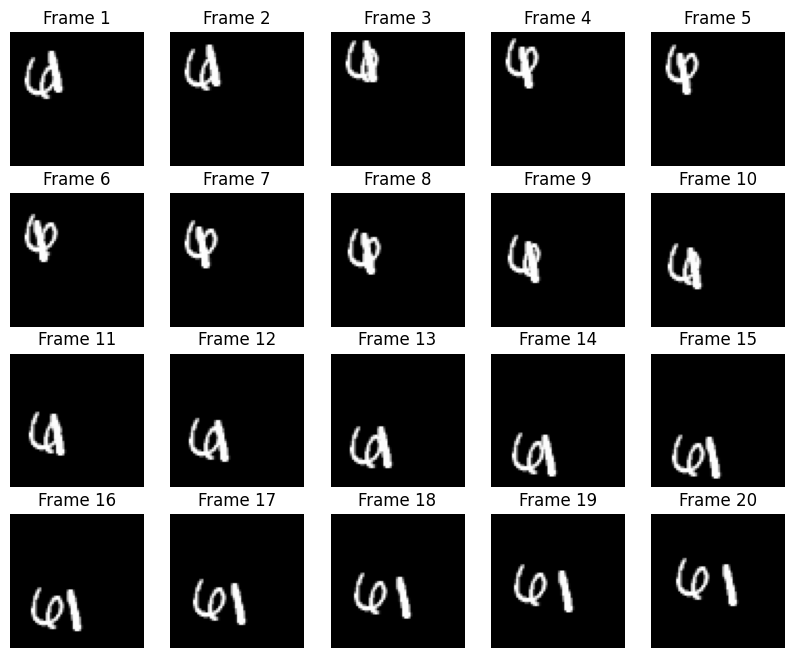

In [10]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"Displaying frames for example {data_choice}")
plt.show()

## Model

In [11]:
def create_model():
    model = keras.Sequential(name="Conv_LSTM")
    
    model.add(
        layers.ConvLSTM2D(
            filters=64,
            kernel_size=(5, 5),
            padding="same",
            activation="relu",
            return_sequences=True,
            input_shape=(None, *x_train.shape[2:])
        )
    )
    model.add(layers.BatchNormalization())
    
    model.add(
        layers.ConvLSTM2D(
            filters=64,
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            return_sequences=True,
        )
    )
    model.add(layers.BatchNormalization())
    
    model.add(
        layers.ConvLSTM2D(
            filters=64,
            kernel_size=(1, 1),
            padding="same",
            activation="relu",
            return_sequences=True,
        )
    )
    
    # spatio-temporal
    model.add(
        layers.Conv3D(
            filters=1,
            kernel_size=(3, 3, 3),
            padding="same",
            activation="sigmoid",
        )
    )

    model.compile(
        loss=keras.losses.binary_crossentropy,
        # optimizer=keras.optimizers.Adam(),
        optimizer=keras.optimizers.legacy.Adam(),  # for arm64
        metrics=["accuracy"]
    )
    return model

## Model Training

In [ ]:
EPOCHS = 10
BATCH_SIZE = 5
MODEL_NAME = f"conv_lstm_{SAMPLES}_{EPOCHS}_{BATCH_SIZE}"
MODEL_PATH = f"trained/{MODEL_NAME}.h5"
print(MODEL_PATH)

# load or create model
if os.path.exists(MODEL_PATH):
    print("loading")
    model = load_model(MODEL_PATH)
else:
    print("creating")
    model = create_model()

    model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_val, y_val),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
        ],
    )
    model.save(MODEL_PATH)

model.summary()

trained/conv_lstm_500_10_5.h5
creating
Epoch 1/10
27/90 [========>.....................] - ETA: 11:28 - loss: 0.2076 - accuracy: 0.9094

## Frame Prediction Visualizations

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict new 10 frames
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0), verbose=1)
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the predicted frames
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

## Predicted Videos

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
mses, psnrs = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame
    
    # Metrics
    mse = np.mean(np.square(original_frames - new_predictions))
    mses.append(mse)
    psnr = 10 * np.log10(255**2 / mse)
    psnrs.append(psnr)

    # Create GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=2)
            predicted_videos.append(gif.getvalue())

In [ ]:
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

In [ ]:
plt.plot(psnrs)
plt.plot(mses)